In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import pickle
import instaloader
from instaloader.exceptions import TooManyRequestsException, ConnectionException, QueryReturnedNotFoundException
import getpass
from datetime import datetime, timedelta
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import malaya
import re
from statistics import mean

bot = instaloader.Instaloader(max_connection_attempts=3)

if not bot.context.is_logged_in:
    print("Instagram login session already closed or not found.")
    print("Instagram content requires an account login to be accessed. Please login at your own risk.\n")
    flag = True
    while flag:
        username = input("Enter username: ")
        password = getpass.getpass("Enter password: ")
        try:
            bot.login(username, password)
            flag = False
        except:
            print("The username or password entered is wrong, please try again.")
            continue

print("\nLogin successful.")
bot.save_session_to_file("session/instaloader-session")

flag = True
while flag:
    pagename = input("Enter Instagram profile name to analyse: ")
    try:
        profile = instaloader.Profile.from_username(bot.context, pagename)
        profile_username = profile.username
        flag = False
    except:
        print("The profile name does not exist, please try again.")
        continue

posts = profile.get_posts()

TODAY = datetime.now()
UNTIL = datetime.now() - timedelta(days = 30)

all_comments = []
print(F"\nFetching comments from {profile_username}'s Instagram page...")
for post in posts:
    postdate = post.date
    if postdate > UNTIL and postdate <= TODAY:
            comments = post.get_comments()
            for comment in comments:
                all_comments.append(comment.text)
                print(F"\nObtained {all_comments.__len__} comments.")
                if all_comments.__len__() >= 300:
                    print(F"\nObtained {all_comments.__len__} comments.")
                    break
    else:
        print(F"\nObtained {all_comments.__len__} comments.")
        break

mly = malaya.sentiment.multinomial()
sia = SentimentIntensityAnalyzer()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')
positive_word_top_100 = np.load('data/positive_word_top_100.npy')
negative_word_top_100 = np.load('data/negative_word_top_100.npy')
learned_positive_words = np.load('data/learned_positive_words.npy')
learned_negative_words = np.load('data/learned_negative_words.npy')

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    learned_positive_words_frequency = 0
    learned_negative_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1

            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1

            if word.lower() in learned_positive_words:
                learned_positive_words_frequency += 1
            if word.lower() in learned_negative_words:
                learned_negative_words_frequency += 1

        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    features["learned_positive_words_frequency"] = learned_positive_words_frequency
    features["learned_negative_words_frequency"] = learned_negative_words_frequency

    return features

classifier = pickle.load(open('models/LogisticRegression.pickle', 'rb'))

comment_texts = []
sentiments = []
for comment in all_comments:
    sentiment = classifier.classify(get_features(comment))
    comment_texts.append(comment)
    sentiments.append(sentiment)

sentiment_df = pd.DataFrame([comment_texts, sentiments]).T
sentiment_df.columns = ['comment', 'sentiment']

pd.set_option("display.width", 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sentiment_counts = sentiment_df['sentiment'].value_counts()

labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#55B9F3', '#F08080']

fig1, ax1 = plt.subplots()

wedgeprops = {'width': 0.4, 'edgecolor': 'w'}
textprops = {'fontsize': 14}
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        wedgeprops=wedgeprops, textprops=textprops, pctdistance=0.8)
ax1.axis('equal')

plt.title(F"{profile_username}'s Page Sentiment", fontsize=16)
plt.show()

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

tweets_df = sentiment_df['comment']
positive_tweets = np.array(tweets_df[sentiment_df['sentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[sentiment_df['sentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    #removes hyperlinks and twitter mentions
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    
positive_word_top_20 = [[word, count] for word, count in positive_fd.most_common(20)]
negative_word_top_20 = [[word, count] for word, count in negative_fd.most_common(20)]

positive_df = pd.DataFrame(positive_word_top_20)
positive_df.columns = ['word', 'count']

negative_df = pd.DataFrame(negative_word_top_20)
negative_df.columns = ['word', 'count']

colors = plt.cm.get_cmap('Set2', len(positive_df))
colors = plt.cm.get_cmap('Set2', len(negative_df))

fig, ax = plt.subplots()
ax.bar(positive_df['word'], positive_df['count'], color=colors(range(len(positive_df))))
ax.set_xticklabels(positive_df['word'], rotation=90)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Words in Positive Comments')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False)
plt.show()

fig, ax = plt.subplots()
ax.bar(negative_df['word'], negative_df['count'], color=colors(range(len(negative_df))))
ax.set_xticklabels(positive_df['word'], rotation=90)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Words in Negative Comments')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False)
plt.show()

print(F"\nComment sentiments on {profile_username}'s posts:")

sentiment_df

Instagram login session already closed or not found.
Instagram content requires an account login to be accessed. Please login at your own risk.


Login successful.
Saved session to session/instaloader-session.

Fetching comments from mydinmalaysia's Instagram page...

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x000001E7BFA9ED80> comments.

Obtained <method-wrapper '__len__' of list object at 0x0000

JSON Query to graphql/query: HTTP error code 401. [retrying; skip with ^C]
JSON Query to graphql/query: HTTP error code 401. [retrying; skip with ^C]


ConnectionException: JSON Query to graphql/query: HTTP error code 401.

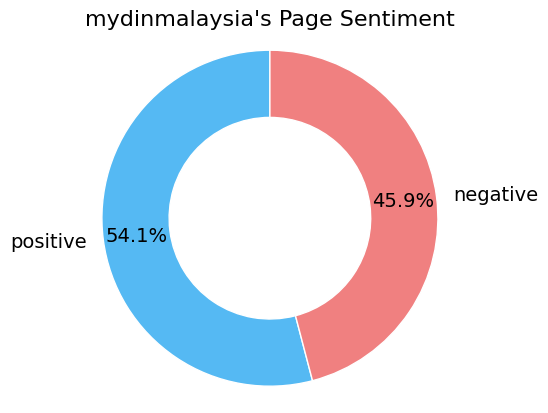

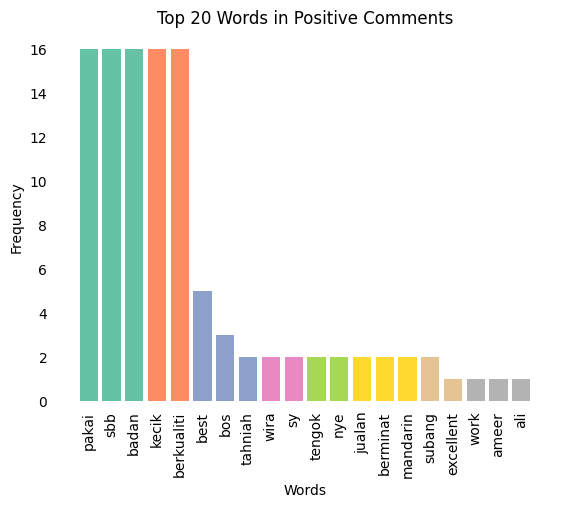

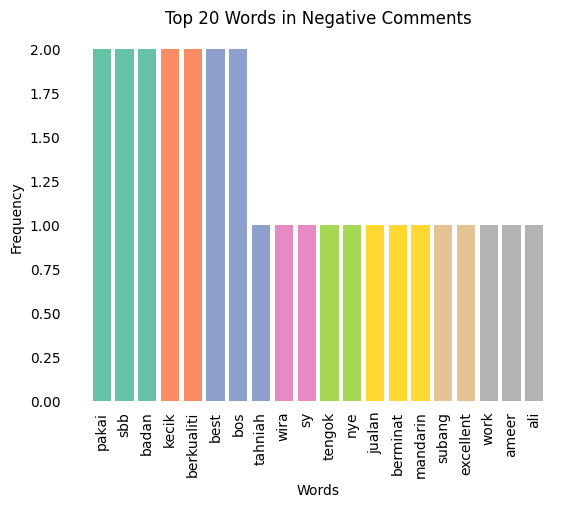


Comment sentiments on mydinmalaysia's posts:
                                              comment sentiment
0                    Hahahaha senang video dia buat 😂  negative
1                                 Excellent work min🔥  positive
2        Tahniah Datuk Wira (Dr) Haji Ameer Ali Mydin  positive
3                             Tahniah Datuk Wira! 👏👏👏  positive
4                                         Terbaik 👍👍👍  positive
5   Mydin jalan baru penang dh ade ke koleksi colo...  positive
6                Letak lerr satu mydin kat cheras ni!  positive
7   Ya sy dah tengok di mydin usj, banyak pilihan ...  positive
8   Kami mendengar dan memahami keprihatinan serta...  negative
9   Mydin melaka baju raya cantik2 .. kali ni kene...  positive
10      @wandaniel805 .baju melayu/baju.kurung rahmah  positive
11     Yea baju Mydin cantik2 dah tengok. Plus murah!  positive
12  Masa anak2 lelaki saya kecik2 dulu mmg beli ba...  negative
13                 Kt semua mydin ade promo ni ke min  neg

In [45]:
import matplotlib.pyplot as plt
import string

mly = malaya.sentiment.multinomial()
sia = SentimentIntensityAnalyzer()

malay_stopwords = np.load('data/malay_stopwords.npy')
positive_malay_words = np.load('data/positive_malay_words.npy')
negative_malay_words = np.load('data/negative_malay_words.npy')
positive_word_top_100 = np.load('data/positive_word_top_100.npy')
negative_word_top_100 = np.load('data/negative_word_top_100.npy')
learned_positive_words = np.load('data/learned_positive_words.npy')
learned_negative_words = np.load('data/learned_negative_words.npy')

def get_features(tweet):
    features = dict()
    top_positive_words_frequency = 0
    top_negative_words_frequency = 0
    positive_malay_words_frequency = 0
    negative_malay_words_frequency = 0
    learned_positive_words_frequency = 0
    learned_negative_words_frequency = 0
    english_compound_scores = list()
    english_positive_scores = list()
    english_negative_scores = list()
    malaya_positive_scores = list()
    malaya_negative_scores = list()

    for sentence in nltk.sent_tokenize(tweet):
        #removes hyperlinks and twitter mentions
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', sentence)
        sentence = re.sub('(@[A-Za-z0-9_]+)','', sentence)

        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_word_top_100:
                top_positive_words_frequency += 1
            if word.lower() in negative_word_top_100:
                top_negative_words_frequency += 1

            if word.lower() in positive_malay_words:
                positive_malay_words_frequency += 1
            if word.lower() in negative_malay_words:
                negative_malay_words_frequency += 1

            if word.lower() in learned_positive_words:
                learned_positive_words_frequency += 1
            if word.lower() in learned_negative_words:
                learned_negative_words_frequency += 1

        malaya_positive_scores.append(mly.predict_proba([sentence])[0]["positive"])
        malaya_negative_scores.append(mly.predict_proba([sentence])[0]["negative"])

        english_compound_scores.append(sia.polarity_scores(sentence)["compound"])
        english_positive_scores.append(sia.polarity_scores(sentence)["pos"])
        english_negative_scores.append(sia.polarity_scores(sentence)["neg"])

    features["malaya_mean_positive"] = mean(malaya_positive_scores)
    features["malaya_mean_negative"] = mean(malaya_negative_scores)
    
    features["english_mean_compound"] = mean(english_compound_scores) + 1
    features["english_mean_positive"] = mean(english_positive_scores)
    features["english_mean_negative"] = mean(english_negative_scores)
    
    features["top_positive_words_frequency"] = top_positive_words_frequency
    features["top_negative_words_frequency"] = top_negative_words_frequency

    features["positive_malay_words_frequency"] = positive_malay_words_frequency
    features["negative_malay_words_frequency"] = negative_malay_words_frequency

    features["learned_positive_words_frequency"] = learned_positive_words_frequency
    features["learned_negative_words_frequency"] = learned_negative_words_frequency

    return features

classifier = pickle.load(open('models/LogisticRegression.pickle', 'rb'))

comment_texts = []
sentiments = []
for comment in all_comments:
    sentiment = classifier.classify(get_features(comment))
    comment_texts.append(comment)
    sentiments.append(sentiment)

sentiment_df = pd.DataFrame([comment_texts, sentiments]).T
sentiment_df.columns = ['comment', 'sentiment']

pd.set_option("display.width", 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sentiment_counts = sentiment_df['sentiment'].value_counts()

labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#55B9F3', '#F08080']

fig1, ax1 = plt.subplots()

wedgeprops = {'width': 0.4, 'edgecolor': 'w'}
textprops = {'fontsize': 14}
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, 
        wedgeprops=wedgeprops, textprops=textprops, pctdistance=0.8)
ax1.axis('equal')

plt.title(F"{profile_username}'s Page Sentiment", fontsize=16)
plt.show()

unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend(malay_stopwords)

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    #if tag.startswith("NN"):
        #return False
    if word in string.punctuation:
        return False
    return True

tweets_df = sentiment_df['comment']
positive_tweets = np.array(tweets_df[sentiment_df['sentiment'] == 'positive'])
negative_tweets = np.array(tweets_df[sentiment_df['sentiment'] == 'negative'])
tweets = np.concatenate((positive_tweets, negative_tweets))

positive_words = []
for positive_tweet in positive_tweets :
    positive_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', positive_tweet)
    positive_tweet = re.sub('(@[A-Za-z0-9_]+)','', positive_tweet)

    positive_tweet = positive_tweet.lower()
    positive_words.extend(nltk.pos_tag(nltk.word_tokenize(positive_tweet)))

positive_words_raw = [word for word, tag in positive_words]

positive_words = [word for word, tag in filter(
    skip_unwanted,
    positive_words)
]

negative_words = []
for negative_tweet in negative_tweets :
    negative_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', negative_tweet)
    negative_tweet = re.sub('(@[A-Za-z0-9_]+)','', negative_tweet)

    negative_tweet = negative_tweet.lower()
    negative_words.extend(nltk.pos_tag(nltk.word_tokenize(negative_tweet)))

negative_words_raw = [word for word, tag in negative_words]

negative_words = [word for word, tag in filter(
    skip_unwanted,
    negative_words)
]

positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)
common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]
    
positive_word_top_20 = [[word, count] for word, count in positive_fd.most_common(20)]
negative_word_top_20 = [[word, count] for word, count in negative_fd.most_common(20)]

positive_df = pd.DataFrame(positive_word_top_20)
positive_df.columns = ['word', 'count']

negative_df = pd.DataFrame(negative_word_top_20)
negative_df.columns = ['word', 'count']

colors = plt.cm.get_cmap('Set2', len(positive_df))
colors = plt.cm.get_cmap('Set2', len(negative_df))

fig, ax = plt.subplots()
ax.bar(positive_df['word'], positive_df['count'], color=colors(range(len(positive_df))))
ax.set_xticklabels(positive_df['word'], rotation=90)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Words in Positive Comments')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False)
plt.show()

fig, ax = plt.subplots()
ax.bar(negative_df['word'], negative_df['count'], color=colors(range(len(negative_df))))
ax.set_xticklabels(negative_df['word'], rotation=90)
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Words in Negative Comments')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(bottom=False, left=False)
plt.show()

print(F"\nComment sentiments on {profile_username}'s posts:")

print(sentiment_df)